# Gaussian Process Regression for Ground Temperature Prediction

Here, the goal is to predict ground temperature at 2m depth using a GP built specifically for this target variable (other temperature depths also valid).

Main reason, is that we know that atmospheric temperature and altitude are near-linear predictors of ground temperature, so we can use kernels specific to these features. 


# What I've tried

- vanilla radial basis function kernel for all features
- instead of constant mean for all features use linear mean for temperature and altitude when estimating ground temperature
- use a categorical feature kernel for stratigraphy index
- when applying this to active layer thickness, scores went down quite a bit (0.9 down to 0.5)

## Things to try

- [ ] estimate temperatures at different depths for summer and winter instead of trying to estimate active layer thickness, use winter and summer temperatures (mean, 10th%, 90th%) etc.
- [ ] add [summer, winter, spring, autumn], [temperatures, precipitation] as features

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# general libraries
import glob
import os
import pathlib
import site
import sys
import warnings
# data handling libraries
import geopandas as gpd
import numpy as np
import pandas as pd
import rioxarray as rxr
import xarray as xr
from tqdm.dask import TqdmCallback as ProgressBarDask
from tqdm.notebook import tqdm as ProgressBar
# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
# machine learning libraries
import gpytorch
from sklearn import gaussian_process as gp
from sklearn import model_selection
import torch

import cryogrid_pytools as cg
import pamir_mlpermafrost as pamir
from pamir_mlpermafrost.models import data as ml_data
from pamir_mlpermafrost.models import gp

In [61]:
from loguru import logger

logger.remove()
logger.add(sys.stderr, level="DEBUG")

2

# Loading data

In [49]:
data_X, data_y = ml_data.load_training_data(sel='S180', target='ground_temp_2m')  #sel=((slice(None), slice(40000, None)),) , 

m = (data_y != 0).values.ravel()  # remove zero values from target
data_X = data_X[m]
data_y = data_y[m]

features = data_X.columns.tolist()

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    data_X, data_y, test_size=0.2, random_state=72,
    stratify=data_X['surface_index']
)

# 1. Data Preprocessing - CRITICAL for GPs
scaler_X = pamir.models.data.StandardScaler_toTensor(skip_columns=[4])
scaler_y = pamir.models.data.StandardScaler_toTensor()

# Scale features
X_train_scaled_tensor = scaler_X.fit_transform(X_train)
X_test_scaled_tensor = scaler_X.transform(X_test)

# Scale target (reshape for sklearn)
y_train_scaled_tensor = scaler_y.fit_transform(y_train).ravel()
y_test_scaled_tensor = scaler_y.transform(y_test).ravel()

In [50]:
# features to dict with ints as keys
{i: features[i] for i in range(len(features))}

{0: 'altitude',
 1: 'slope_angle',
 2: 'aspect_cos',
 3: 'aspect_sin',
 4: 'surface_index',
 5: 'albedo',
 6: 'emissivity',
 7: 'snow_melt_doy',
 8: 'temperature',
 9: 'precipitation',
 10: 'temp2m_DJF_q05',
 11: 'temp2m_JJA_q05',
 12: 'temp2m_MAM_q05',
 13: 'temp2m_SON_q05',
 14: 'temp2m_DJF_q50',
 15: 'temp2m_JJA_q50',
 16: 'temp2m_MAM_q50',
 17: 'temp2m_SON_q50',
 18: 'temp2m_DJF_q95',
 19: 'temp2m_JJA_q95',
 20: 'temp2m_MAM_q95',
 21: 'temp2m_SON_q95',
 22: 'precip_DJF_q05',
 23: 'precip_JJA_q05',
 24: 'precip_MAM_q05',
 25: 'precip_SON_q05',
 26: 'precip_DJF_q50',
 27: 'precip_JJA_q50',
 28: 'precip_MAM_q50',
 29: 'precip_SON_q50',
 30: 'precip_DJF_q95',
 31: 'precip_JJA_q95',
 32: 'precip_MAM_q95',
 33: 'precip_SON_q95'}

In [62]:
model = gp.ground_temp.GPMixedMeanCatIndex(
    X_train_scaled_tensor, 
    y_train_scaled_tensor, 
    gpytorch.likelihoods.GaussianLikelihood(), 
    linear_mean_idx=[0, 8],
    cat_idx=[4],
)

2025-07-30 11:54:03.885 | INFO     | pamir_mlpermafrost.models.gp.ground_temp:__init__:45 - categories=tensor([1., 2., 3., 4.])


In [63]:
model, losses = gp.train.train_mll(
    model, 
    X_train_scaled_tensor, 
    y_train_scaled_tensor, 
    tolerance=1e-3, 
    patience=10, 
    n_iters=500)

2025-07-30 11:54:06.410 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:06.601 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:06.788 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:06.985 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:07.178 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:07.372 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:07.555 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:07.738 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:07.925 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:08.108 | DEBUG    | pamir_mlp

Iter 10/500 - Loss: 2.794421


2025-07-30 11:54:08.508 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:08.691 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:08.876 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:09.095 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:09.320 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:09.504 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:09.689 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:09.872 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:10.054 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:10.236 | DEBUG    | pamir_mlp

Iter 20/500 - Loss: 2.160617


2025-07-30 11:54:10.423 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:10.612 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:10.800 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:10.985 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:11.168 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:11.382 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:11.569 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:11.752 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:11.936 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:12.120 | DEBUG    | pamir_mlp

Iter 30/500 - Loss: 1.832114


2025-07-30 11:54:12.306 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:12.493 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:12.684 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:12.873 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:13.069 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:13.253 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:13.437 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:13.623 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:13.805 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:13.997 | DEBUG    | pamir_mlp

Iter 40/500 - Loss: 1.651896


2025-07-30 11:54:14.250 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:14.436 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:14.625 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:14.808 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:14.990 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:15.171 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:15.355 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:15.540 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:15.722 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:15.905 | DEBUG    | pamir_mlp

Iter 50/500 - Loss: 1.531229


2025-07-30 11:54:16.092 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:16.276 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:16.460 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:16.645 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:16.827 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:17.010 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:17.194 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:17.380 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:17.570 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:17.760 | DEBUG    | pamir_mlp

Iter 60/500 - Loss: 1.431944


2025-07-30 11:54:18.024 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:18.216 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:18.407 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:18.594 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:18.779 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:18.964 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:19.147 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:19.330 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:19.515 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:19.709 | DEBUG    | pamir_mlp

Iter 70/500 - Loss: 1.347714


2025-07-30 11:54:19.904 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:20.110 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:20.350 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:20.544 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:20.741 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:21.036 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=1
2025-07-30 11:54:21.244 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:21.446 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:21.636 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:21.828 | DEBUG    | pamir_mlp

Iter 80/500 - Loss: 1.259304


2025-07-30 11:54:22.013 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:22.201 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=1
2025-07-30 11:54:22.387 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:22.573 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:22.757 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:22.941 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:23.126 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:23.309 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:23.497 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:23.682 | DEBUG    | pamir_mlp

Iter 90/500 - Loss: 1.164357


2025-07-30 11:54:23.876 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:24.070 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=1
2025-07-30 11:54:24.259 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:24.442 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:24.628 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:24.847 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:25.061 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=1
2025-07-30 11:54:25.252 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:25.437 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:25.622 | DEBUG    | pamir_mlp

Iter 100/500 - Loss: 1.074819


2025-07-30 11:54:25.815 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:26.002 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:26.187 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:26.371 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:26.555 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:26.739 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:26.923 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:27.107 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:27.290 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:27.474 | DEBUG    | pamir_mlp

Iter 110/500 - Loss: 0.980127


2025-07-30 11:54:27.666 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:27.866 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:28.053 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:28.237 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=1
2025-07-30 11:54:28.421 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:28.606 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:28.790 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:28.981 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:29.166 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:29.350 | DEBUG    | pamir_mlp

Iter 120/500 - Loss: 0.885974


2025-07-30 11:54:29.538 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:29.723 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:29.908 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:30.092 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=1
2025-07-30 11:54:30.277 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:30.460 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:30.646 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=1
2025-07-30 11:54:30.830 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:31.017 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:31.202 | DEBUG    | pamir_mlp

Iter 130/500 - Loss: 0.792655


2025-07-30 11:54:31.389 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:31.576 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:31.760 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:31.946 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:32.132 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=1
2025-07-30 11:54:32.315 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:32.499 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=1
2025-07-30 11:54:32.684 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:32.869 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:33.054 | DEBUG    | pamir_mlp

Iter 140/500 - Loss: 0.693614


2025-07-30 11:54:33.246 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:33.432 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:33.619 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:33.868 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:34.053 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:34.238 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:34.423 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:34.624 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:34.811 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:34.997 | DEBUG    | pamir_mlp

Iter 150/500 - Loss: 0.600859


2025-07-30 11:54:35.187 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:35.379 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=1
2025-07-30 11:54:35.566 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:35.753 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:35.937 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:36.121 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:36.305 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:36.490 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:36.674 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:36.857 | DEBUG    | pamir_mlp

Iter 160/500 - Loss: 0.516092


2025-07-30 11:54:37.043 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:37.229 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=1
2025-07-30 11:54:37.417 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:37.601 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:37.784 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:37.969 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:38.158 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=1
2025-07-30 11:54:38.341 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:38.526 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=1
2025-07-30 11:54:38.710 | DEBUG    | pamir_mlp

Iter 170/500 - Loss: 0.438290


2025-07-30 11:54:38.904 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:39.107 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=1
2025-07-30 11:54:39.309 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:39.500 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:39.687 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:39.890 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=1
2025-07-30 11:54:40.089 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:40.331 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=1
2025-07-30 11:54:40.547 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0


Iter 180/500 - Loss: 0.385192


2025-07-30 11:54:40.753 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:40.960 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=1
2025-07-30 11:54:41.162 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:41.362 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:41.565 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=1
2025-07-30 11:54:41.764 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:41.969 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=1
2025-07-30 11:54:42.174 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:42.377 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:42.578 | DEBUG    | pamir_mlp

Iter 190/500 - Loss: 0.315814


2025-07-30 11:54:42.781 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:42.985 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=1
2025-07-30 11:54:43.191 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:43.396 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=1
2025-07-30 11:54:43.600 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:43.806 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:44.009 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:44.211 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:44.415 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=1
2025-07-30 11:54:44.627 | DEBUG    | pamir_mlp

Iter 200/500 - Loss: 0.268863


2025-07-30 11:54:44.847 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=1
2025-07-30 11:54:45.054 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:45.260 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:45.464 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:45.669 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:45.875 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=1
2025-07-30 11:54:46.082 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:46.287 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=1
2025-07-30 11:54:46.488 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=0
2025-07-30 11:54:46.707 | DEBUG    | pamir_mlp

Iter 210/500 - Loss: 0.255290


2025-07-30 11:54:46.991 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=2
2025-07-30 11:54:47.215 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=1
2025-07-30 11:54:47.439 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=2
2025-07-30 11:54:47.644 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=1
2025-07-30 11:54:47.850 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=2
2025-07-30 11:54:48.077 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=3
2025-07-30 11:54:48.298 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=4
2025-07-30 11:54:48.524 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=5
2025-07-30 11:54:48.749 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=4
2025-07-30 11:54:48.971 | DEBUG    | pamir_mlp

Iter 220/500 - Loss: 0.229064


2025-07-30 11:54:49.196 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=4
2025-07-30 11:54:49.419 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=3
2025-07-30 11:54:49.643 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=4
2025-07-30 11:54:49.878 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=5
2025-07-30 11:54:50.106 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=6
2025-07-30 11:54:50.330 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=5
2025-07-30 11:54:50.560 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=6
2025-07-30 11:54:50.782 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=5
2025-07-30 11:54:51.005 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=4
2025-07-30 11:54:51.253 | DEBUG    | pamir_mlp

Iter 230/500 - Loss: 0.259891


2025-07-30 11:54:51.501 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=4
2025-07-30 11:54:51.732 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=3
2025-07-30 11:54:51.963 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=2
2025-07-30 11:54:52.194 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=3
2025-07-30 11:54:52.422 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=2
2025-07-30 11:54:52.665 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=3
2025-07-30 11:54:52.912 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=4
2025-07-30 11:54:53.164 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=3
2025-07-30 11:54:53.414 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=4
2025-07-30 11:54:53.650 | DEBUG    | pamir_mlp

Iter 240/500 - Loss: 0.227874


2025-07-30 11:54:53.882 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=2
2025-07-30 11:54:54.138 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=3
2025-07-30 11:54:54.391 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=2
2025-07-30 11:54:54.625 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=1
2025-07-30 11:54:54.875 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=2
2025-07-30 11:54:55.104 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=1
2025-07-30 11:54:55.356 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=2
2025-07-30 11:54:55.614 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=3
2025-07-30 11:54:55.870 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=4
2025-07-30 11:54:56.103 | DEBUG    | pamir_mlp

Iter 250/500 - Loss: 0.199651


2025-07-30 11:54:56.362 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=4
2025-07-30 11:54:56.620 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=3
2025-07-30 11:54:56.854 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=2
2025-07-30 11:54:57.108 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=3
2025-07-30 11:54:57.367 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=4
2025-07-30 11:54:57.620 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=3
2025-07-30 11:54:57.850 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=2
2025-07-30 11:54:58.099 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=3
2025-07-30 11:54:58.329 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=2
2025-07-30 11:54:58.564 | DEBUG    | pamir_mlp

Iter 260/500 - Loss: 0.210934


2025-07-30 11:54:58.822 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=4
2025-07-30 11:54:59.089 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=5
2025-07-30 11:54:59.347 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=4
2025-07-30 11:54:59.606 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=5
2025-07-30 11:54:59.866 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=6
2025-07-30 11:55:00.112 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=5
2025-07-30 11:55:00.378 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=6
2025-07-30 11:55:00.643 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=7
2025-07-30 11:55:00.903 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=6
2025-07-30 11:55:01.135 | DEBUG    | pamir_mlp

Iter 270/500 - Loss: 0.229202


2025-07-30 11:55:01.413 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=6
2025-07-30 11:55:01.744 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=7
2025-07-30 11:55:02.009 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=8
2025-07-30 11:55:02.270 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=9
2025-07-30 11:55:02.528 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=8
2025-07-30 11:55:02.790 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=9
2025-07-30 11:55:03.028 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=8
2025-07-30 11:55:03.288 | DEBUG    | pamir_mlpermafrost.models.gp.train:train_mll:29 - no_improve_count=9


Converged at iteration 279


In [64]:
scores, y_pred, y_pred_std = gp.train.eval(model, X_train_scaled_tensor, y_train_scaled_tensor, scaler_y)

/Users/luke/Work/PAMIR/pamir-MLpermafrost/.venv/lib/python3.12/site-packages/gpytorch/models/exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Test Set Performance (Original Scale):
MSE: 0.2531
RMSE: 0.5031
MAE: 0.3379
R²: 0.9803
Predicted Std Dev: 2.0974


In [65]:
scores, y_pred, y_pred_std = gp.train.eval(model, X_test_scaled_tensor, y_test_scaled_tensor, scaler_y)

Test Set Performance (Original Scale):
MSE: 1.1094
RMSE: 1.0533
MAE: 0.6884
R²: 0.9101
Predicted Std Dev: 2.1332


# Inference 

In [66]:
fname_spatial = '../../pamir-CryoGrid/forcing/spatial_variables-710w365s750e400n-100m.zarr/'
fname_cryogrid = '../../pamir-CryoGrid/output/cluster_config-k1500-pamir_S180-exp1.zarr/'

da_cluster_labels = xr.open_zarr(fname_cryogrid, consolidated=True).cluster_labels.compute()

ds_spatial = xr.open_zarr(fname_spatial, consolidated=True).isel(x=slice(1000, 2000), y=slice(1000, 2000))
mask = (
    (ds_spatial.altitude > 3100)
    &
    (ds_spatial.surface_index > 0)
)

In [67]:
inference_X = ml_data.load_inference_data_from_zarr(ds_spatial, features=X_train.columns.tolist())
inference_X_scaled_tensor = scaler_X.transform(inference_X)

: 

In [ ]:
yhat_mu, yhat_sigma = gp.inference.predict(model, inference_X_scaled_tensor, scaler_y)

yhat_mu_da = yhat_mu.set_index(inference_X.index).iloc[:, 0].to_xarray()
yhat_sigma_da = pd.Series(yhat_sigma.numpy(), index=inference_X.index).to_xarray()

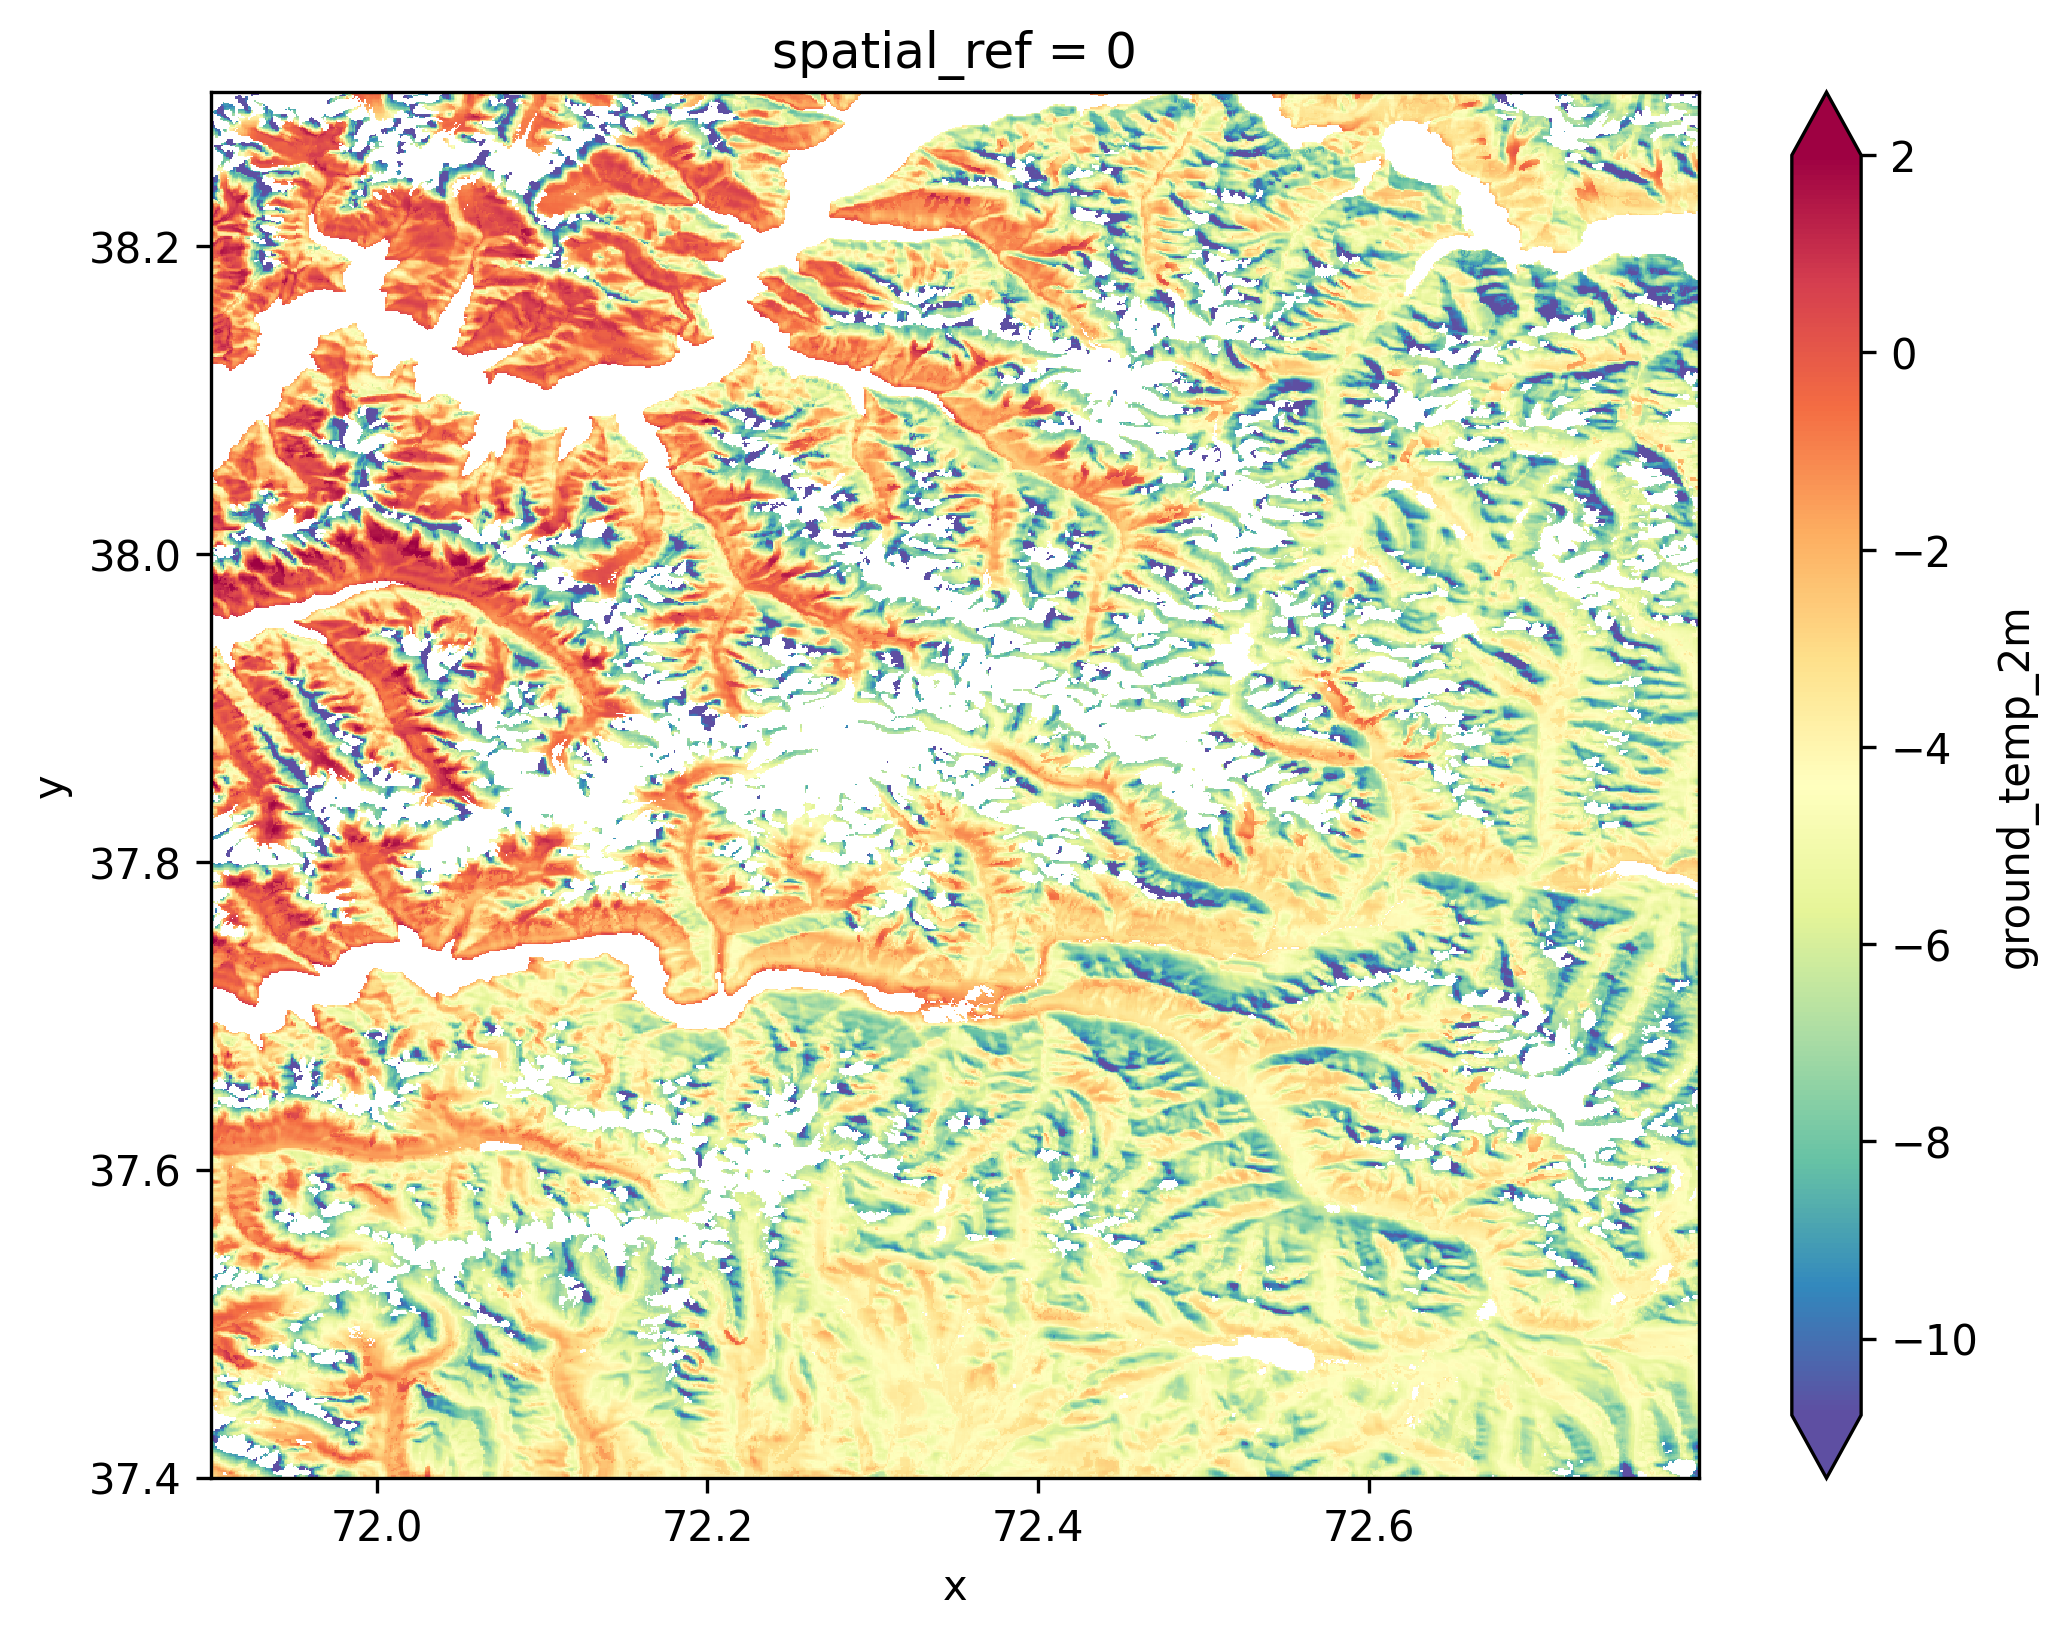

In [46]:
# Plot comparison
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=300)

img0 = (
    # yhat_sigma_da
    yhat_mu_da
    # .where(lambda x: x<0)
    .where(mask)
    .plot.imshow(
        ax=ax, 
        cmap='Spectral_r', 
        robust=True,
        vmax=2, center=False
    ))

In [47]:
y_da_unmapped = (
    data_y
    # .loc['N180']
    # .loc[40000:50000]
    .iloc[:, 0]
    .to_xarray()
    .assign_coords(tag=lambda x: x.tag - 10000)
    .rename(tag='index'))
y_da = cg.spatial_clusters.map_gridcells_to_clusters(
    y_da_unmapped,
    da_cluster_labels,    
).reindex_like(yhat_mu_da, method='nearest')

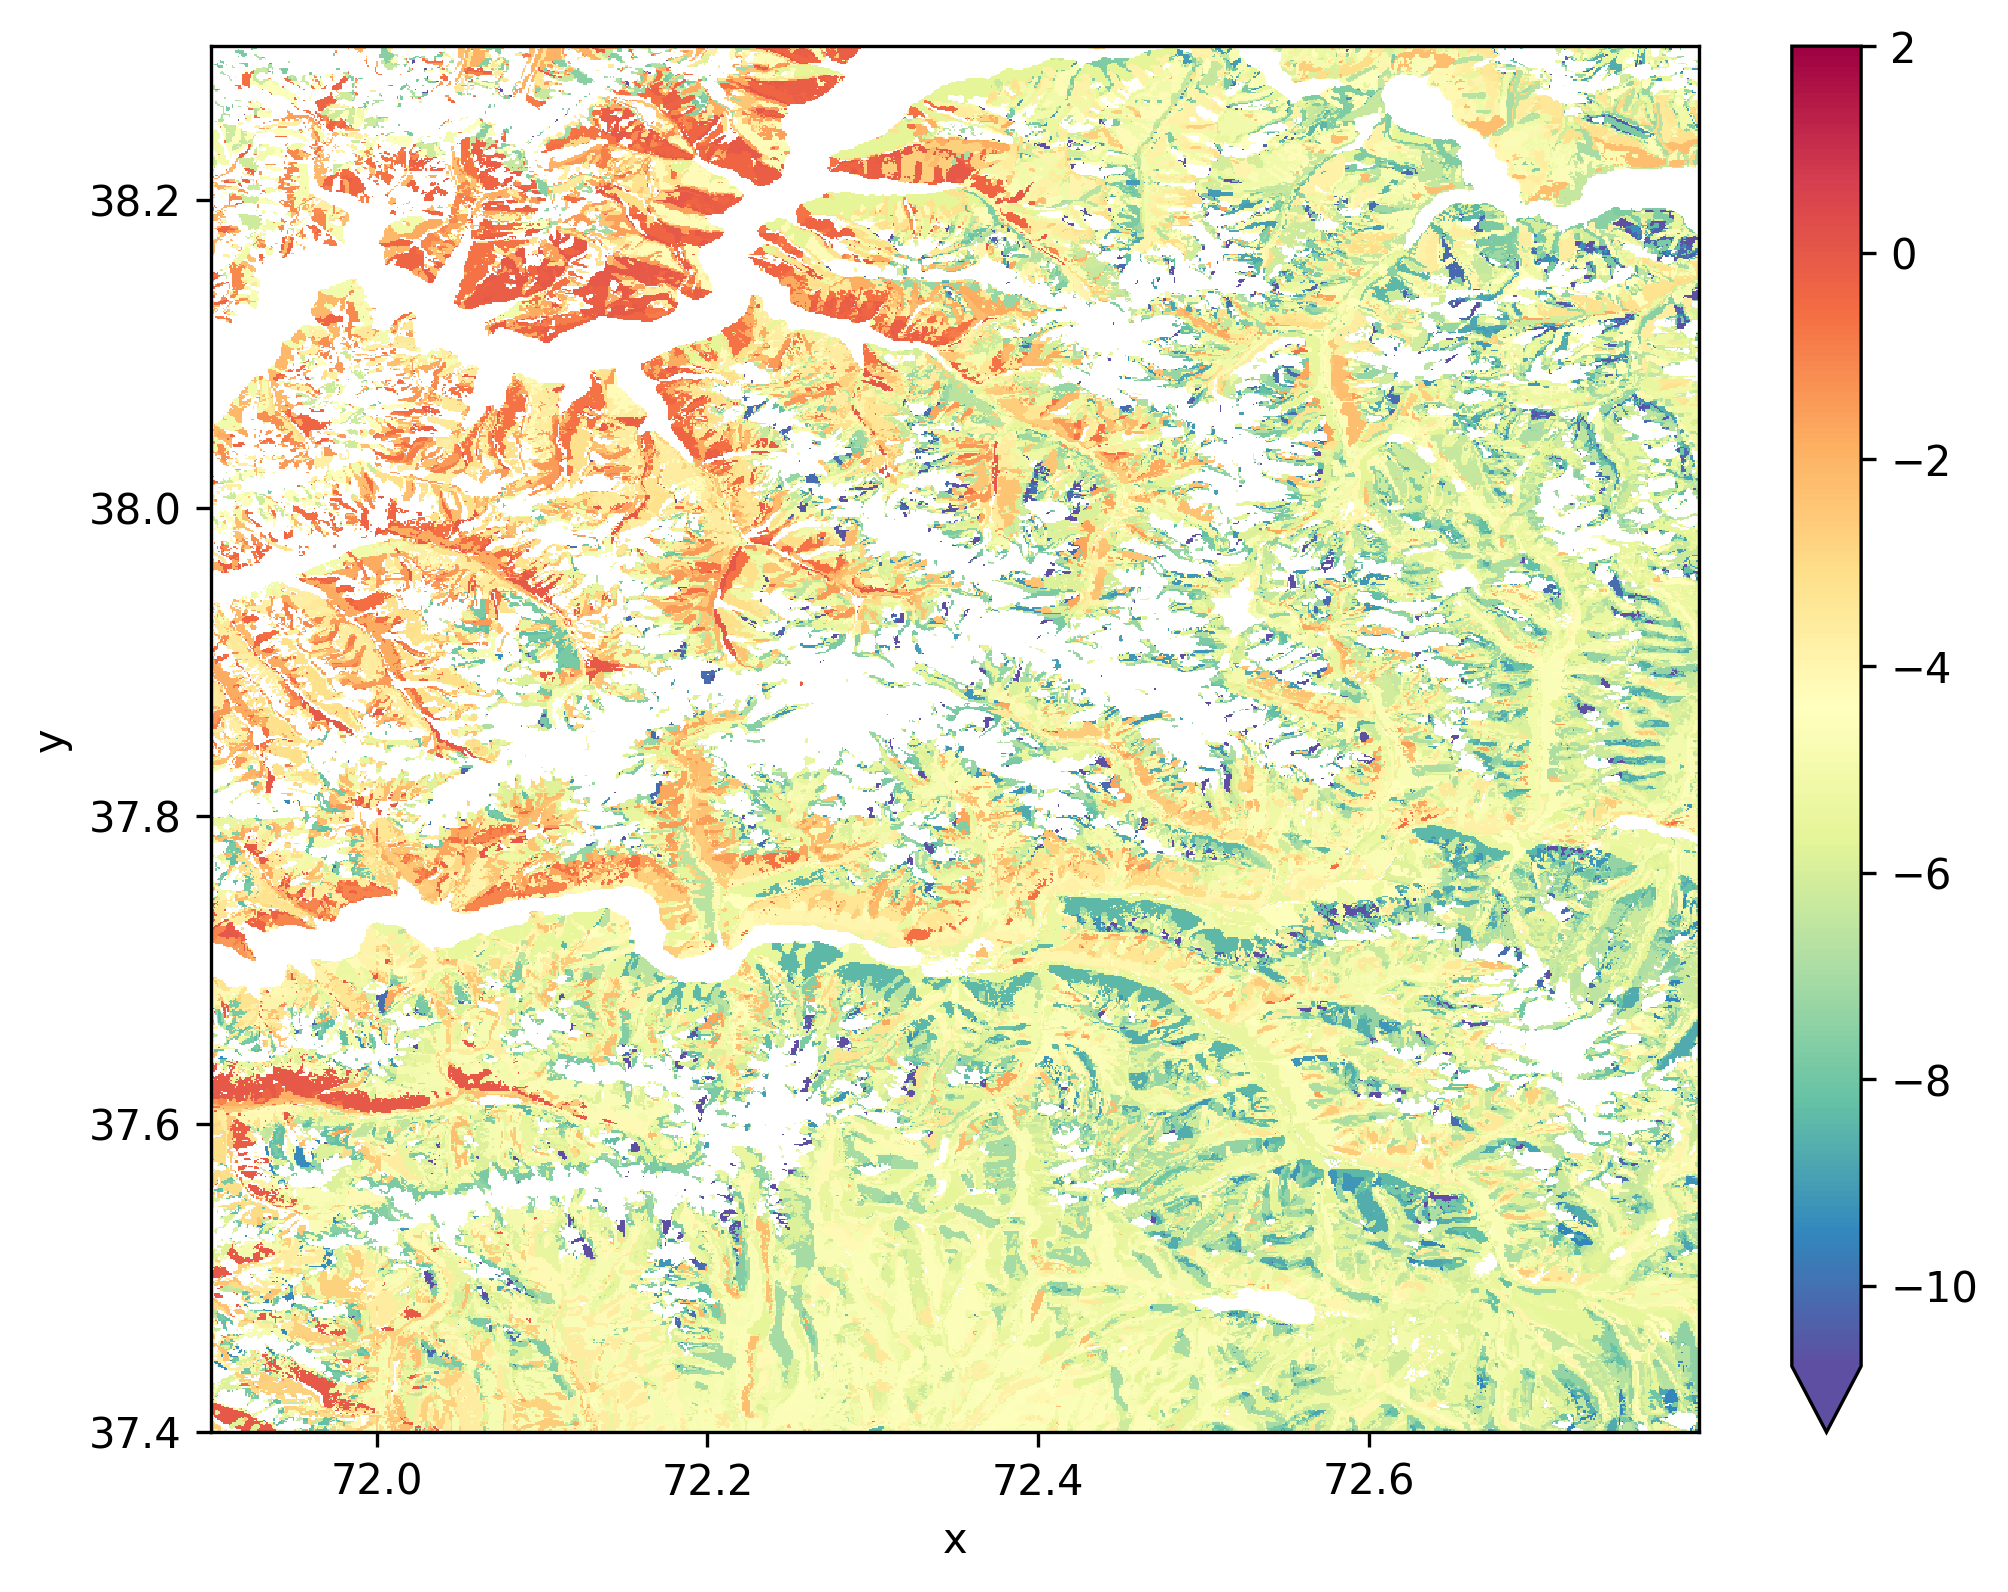

In [48]:
# Plot comparison
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=300)

img = (
    # yhat_sigma_da
    y_da
    # .where(mask)
    .where(lambda x: x<0)
    .plot.imshow(
        ax=ax, 
        cmap=img0.cmap, 
        vmin=img0.get_clim()[0], 
        vmax=img0.get_clim()[1]
    ))